## 1. Cookie Cat
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

Initially the first gate was placed at level 30, but using AB-test I will decide whether or not the first gate should be moved to level 40 in the context of the impact on player retention.

In [6]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

# Showing the first few rows
df.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [10]:
print(df.shape)
print(df.userid.nunique())

(90189, 5)
90189


90189 players installed the game while the AB-test was running

## 2. The AB-test data

userid - a unique number that identifies each player.
version - whether the player was put in the control group (gate at level 30) or the group with the moved gate (gate at level 40)
sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
retention_1 - did the player come back and play 1 day after installing?
retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. 


In [11]:
# Counting the number of players in each AB group.
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

## 3. Data Distribution

Text(0, 0.5, 'Userid Count')

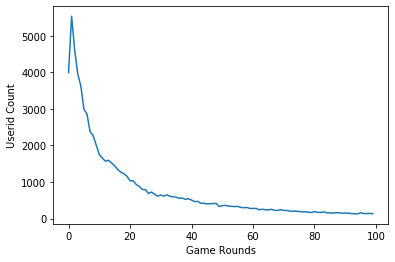

In [12]:
%matplotlib inline
df.groupby('sum_gamerounds')['userid']
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(x='sum_gamerounds',y='userid')
ax.set_xlabel("Game Rounds")
ax.set_ylabel("Userid Count")

Text(0, 0.5, 'Userid Count')

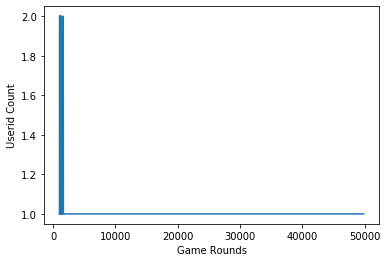

In [13]:
# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.tail(100).plot(x='sum_gamerounds',y='userid')
ax.set_xlabel("Game Rounds")
ax.set_ylabel("Userid Count")

Some players install the game but then never play it, some players just play a couple of game rounds in their first week, and some get really hooked

## 4. 1 Day Retention

- A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it.  
- The higher 1-day retention is, the easier it is to retain players and build a large player base.

In [15]:
# The % of users that came back the day after they installed (will be used as benchmark)
df['retention_1'].mean()

0.4452095044850259

In [16]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

## 5. Bootstrap
- Bootstrapping: I will repeatedly re-sample the dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

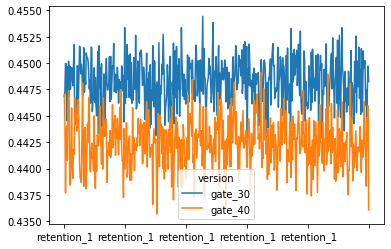

In [17]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. (Note that in this notebook we have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10 000)

## 6. Zooming in on the difference


Text(0, 0.5, '% Difference in means')

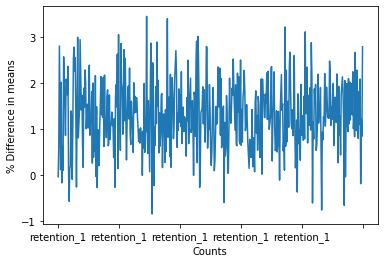

In [18]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = ((boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40']*100)

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot()
ax.set_xlabel("Counts")
ax.set_ylabel("% Difference in means")

In [19]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff']>0).mean()

# Pretty printing the probability
print(prob)
print('{:.1%}'.format(prob))

0.958
95.8%


There is a high probability that 1-day retention is better when the gate is at level 30.
However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

## 7. 7 Day Retention by AB-group


After having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

In [20]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%).This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

## 8. Bootstrap again


100.0%


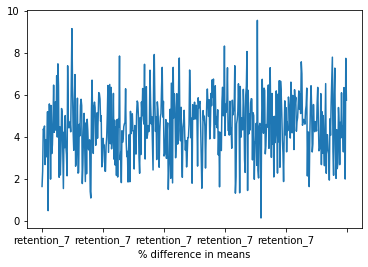

In [21]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean =df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d=pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30']-boot_7d['gate_40'])/boot_7d['gate_40']*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot()
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff']>0).mean()

# Pretty printing the probability
print('{:.1%}'.format(prob))

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

## 9.  The conclusion
If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40.

For the further analysis, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.


So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously.By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.